In [60]:
from pyro.infer import MCMC, NUTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from BNN_model import BayesianNN
from sklearn.preprocessing import StandardScaler

# Use predictive distribution
from pyro.infer import Predictive


### Read the data 

In [18]:
df_mp = pd.read_csv('/home/april-ai/Desktop/UQ/MP_Data/materials_data_10k_cleaned.csv')

### Train-test split

In [ ]:
y = df_mp['band_gap'].values
excluded = ["material_id", "composition", "formula_pretty", "symmetry", "structure"]
X = df_mp.drop(excluded, axis=1)

#print("There are {} possible descriptors:\n\n{}".format(X.shape[1], X.columns.values))


There are 138 possible descriptors:

['nsites' 'volume' 'density' 'formation_energy_per_atom'
 'energy_above_hull' 'band_gap' 'MagpieData minimum Number'
 'MagpieData maximum Number' 'MagpieData range Number'
 'MagpieData mean Number' 'MagpieData avg_dev Number'
 'MagpieData mode Number' 'MagpieData minimum MendeleevNumber'
 'MagpieData maximum MendeleevNumber' 'MagpieData range MendeleevNumber'
 'MagpieData mean MendeleevNumber' 'MagpieData avg_dev MendeleevNumber'
 'MagpieData mode MendeleevNumber' 'MagpieData minimum AtomicWeight'
 'MagpieData maximum AtomicWeight' 'MagpieData range AtomicWeight'
 'MagpieData mean AtomicWeight' 'MagpieData avg_dev AtomicWeight'
 'MagpieData mode AtomicWeight' 'MagpieData minimum MeltingT'
 'MagpieData maximum MeltingT' 'MagpieData range MeltingT'
 'MagpieData mean MeltingT' 'MagpieData avg_dev MeltingT'
 'MagpieData mode MeltingT' 'MagpieData minimum Column'
 'MagpieData maximum Column' 'MagpieData range Column'
 'MagpieData mean Column' 'MagpieData

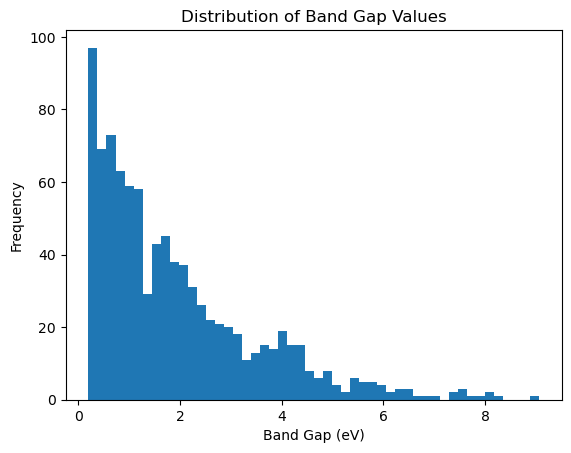

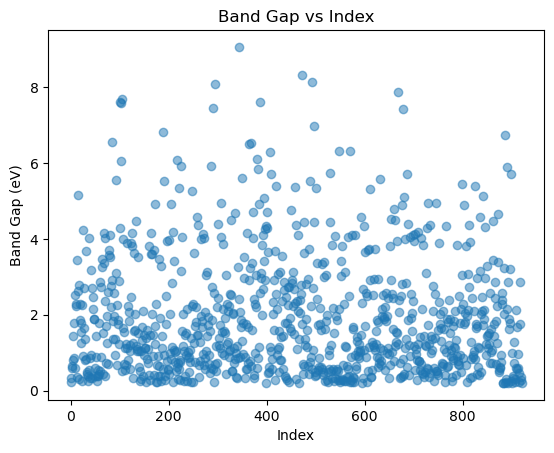

In [31]:
#visualize the distrubution of  the band gap data 

plt.hist(y, bins=50)
plt.xlabel('Band Gap (eV)')
plt.ylabel('Frequency')
plt.title('Distribution of Band Gap Values')
plt.show()

#visualise the bannd gap vs index 
plt.scatter(range(len(y)), y, alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Band Gap (eV)')
plt.title('Band Gap vs Index')
plt.show()

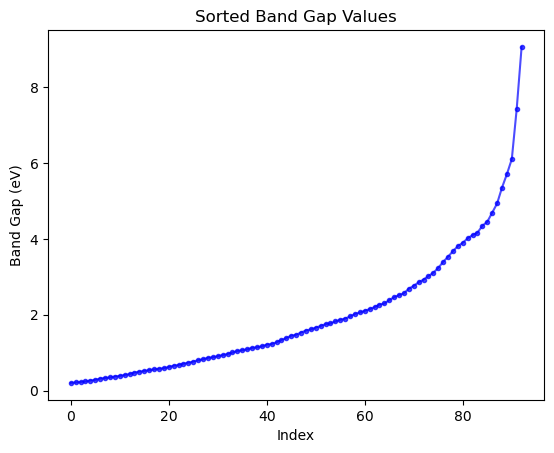

In [39]:
#visualise sorted band gap values
sorted_y = np.sort(y)
plt.plot(sorted_y[: : 10], marker='o', markersize=3, linestyle='-', color='blue', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Band Gap (eV)')
plt.title('Sorted Band Gap Values')
plt.show()

In [40]:
#Train tes split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values if hasattr(y_train, 'values') else y_train, dtype=torch.float32)

# For test set as well
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

In [90]:

# Drop non-numeric / irrelevant fields
non_feature_cols = [
    "sites", "composition", "formula_pretty", "structure", "symmetry",
    "material_id"
]
df = df_mp.drop(columns=non_feature_cols, errors='ignore')
df = df.dropna(subset=["band_gap"])

# Save original indices
original_indices = np.arange(len(df))

# Split first — before scaling — and keep track of original indices
X_raw = df.drop(columns=["band_gap"])
y_raw = df["band_gap"]

X_train_raw, X_test_raw, y_train_raw, y_test_raw, idx_train, idx_test = train_test_split(
    X_raw, y_raw, original_indices, test_size=0.2, random_state=42
)

# Now normalize using *training data only*

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_x.fit_transform(X_train_raw)
X_test = scaler_x.transform(X_test_raw)

y_train = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test_raw.values.reshape(-1, 1)).ravel()

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


### MCMC Sample and run the model 

In [65]:
import importlib
import BNN_model
importlib.reload(BNN_model)
from BNN_model import BayesianNN

In [66]:
model = BayesianNN(input_dim=X_train.shape[1])  # Initialise BayesianNN model

nuts_kernel = NUTS(model)  # 'model' is your BayesianNN
mcmc = MCMC(nuts_kernel, num_samples=300, warmup_steps=200)
mcmc.run(X_train_tensor, y_train_tensor)
posterior_samples = mcmc.get_samples()


Sample: 100%|██████████| 500/500 [34:15,  4.11s/it, step size=4.19e-03, acc. prob=0.701]


### Make predictions 

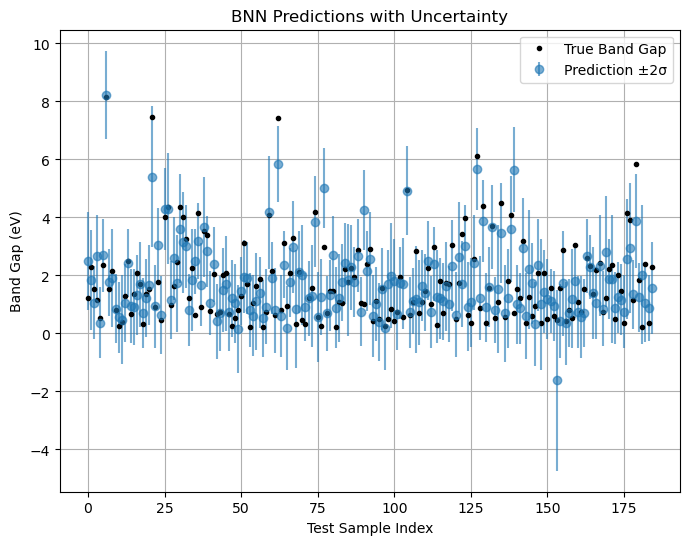

In [91]:
predictive = Predictive(model, posterior_samples, return_sites=["obs"])
preds = predictive(X_test_tensor)["obs"]  # shape: [num_samples, num_test_points]

mean_pred = preds.mean(dim=0).numpy()
std_pred = preds.std(dim=0).numpy()

# Inverse-transform band gaps
mean_pred_actual = scaler_y.inverse_transform(mean_pred.reshape(-1, 1)).ravel()
std_pred_actual = std_pred * scaler_y.scale_[0]  # std scales linearly

y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Plot with confidence interval
plt.figure(figsize=(8, 6))
plt.errorbar(np.arange(len(mean_pred_actual)), mean_pred_actual, yerr=2*std_pred_actual, fmt='o', label="Prediction ±2σ", alpha=0.6)
plt.plot(np.arange(len(y_test_actual)), y_test_actual, 'k.', label="True Band Gap")
plt.xlabel("Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("BNN Predictions with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()


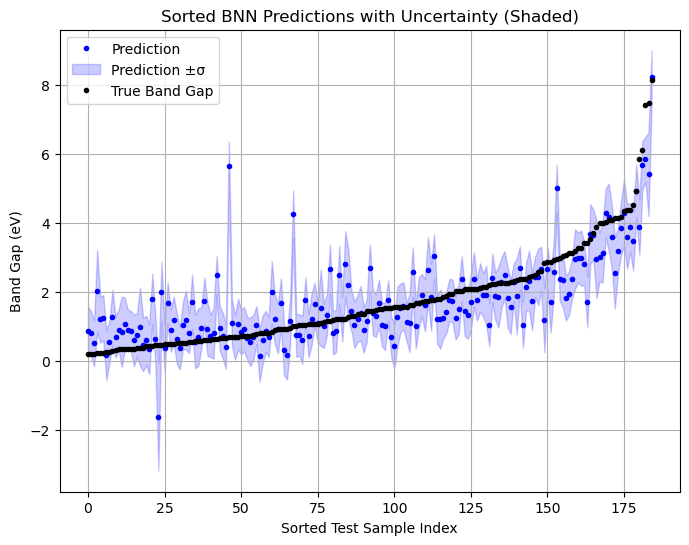

In [92]:

sorted_indices = np.argsort(y_test_actual)
sorted_y_test_actual = y_test_actual[sorted_indices]
sorted_mean_pred_actual = mean_pred_actual[sorted_indices]
sorted_std_pred_actual = std_pred_actual[sorted_indices]

x = np.arange(len(sorted_mean_pred_actual))
upper = sorted_mean_pred_actual + sorted_std_pred_actual
lower = sorted_mean_pred_actual - sorted_std_pred_actual

plt.figure(figsize=(8, 6))
plt.plot(x, sorted_mean_pred_actual, 'b.', label="Prediction")
plt.fill_between(x, lower, upper, color='blue', alpha=0.2, label="Prediction ±σ")
plt.plot(x, sorted_y_test_actual, 'k.', label="True Band Gap")
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("Sorted BNN Predictions with Uncertainty (Shaded)")
plt.legend()
plt.grid(True)
plt.show()

In [93]:
#get information about outliers 
outliers = np.abs(sorted_mean_pred_actual - sorted_y_test_actual) > 1.5 # Define outliers as those with a difference greater than 0.2 eV
outlier_indices = np.where(outliers)[0]
sorted_y_test_actual = y_test_actual[sorted_indices]
sorted_mean_pred_actual = mean_pred_actual[sorted_indices]
print("Outlier Indices:", outlier_indices)
print("Outlier Predictions:", sorted_mean_pred_actual[outlier_indices])
print("Outlier True Values:", sorted_y_test_actual[outlier_indices])


Outlier Indices: [  3  23  24  42  46  67  84 149 153 163 172 180 182 183]
Outlier Predictions: [ 2.0226114 -1.6160135  2.008932   2.4861352  5.6386604  4.2525015
  2.8176038  1.1762342  5.005673   1.720398   2.5511863  3.8802605
  5.840709   5.409381 ]
Outlier True Values: [0.2312 0.4727 0.4773 0.6412 0.6975 1.0035 1.2319 2.8504 2.9654 3.4296
 4.1443 5.8537 7.4289 7.4639]


In [94]:
outlier_test_indices = sorted_indices[outlier_indices]

In [95]:
# Map test index to original DataFrame index
outlier_original_indices = idx_test[outlier_test_indices]


In [97]:


outliers_df = df_mp.iloc[outlier_original_indices]


# Show selected info
print(outliers_df[["composition", "band_gap"]])


     composition  band_gap
5659      N4 Cl1    0.2312
5727      U1 Cl2    0.4727
4206      La1 N3    0.4773
3660       V2 F9    0.6412
4132     Nd6 F17    0.6975
3816      H11 O8    1.0035
2374      B1 Br1    1.2319
5760      Au1 C2    2.8504
4766       C5 F6    2.9654
1466     Pr1 Br3    3.4296
1396      Be1 I2    4.1443
1440      Al2 O3    5.8537
2975       Y1 F3    7.4289
925       Be1 O1    7.4639


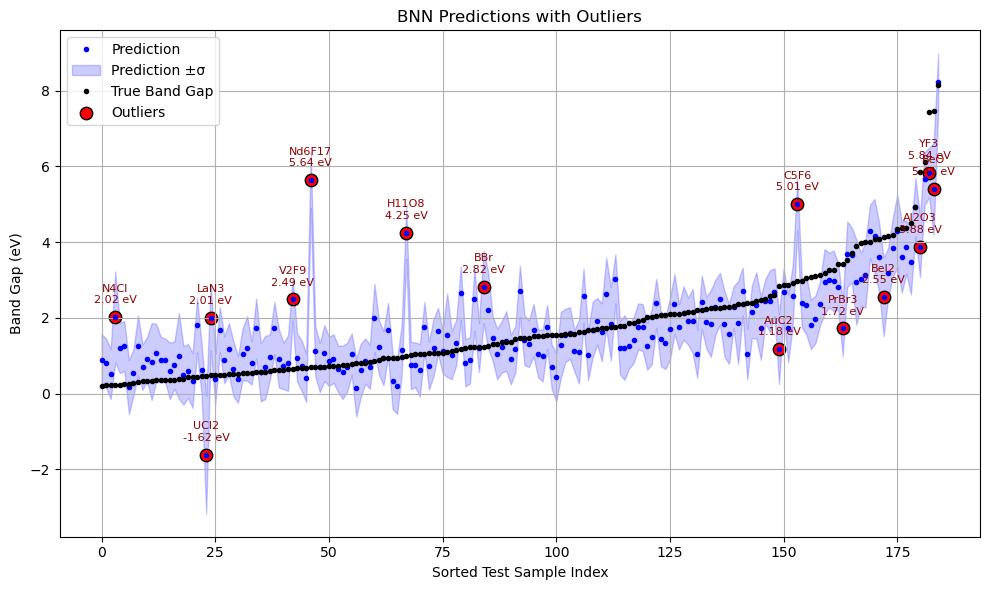

In [109]:
import matplotlib.pyplot as plt
import numpy as np

# Map sorted → test → original index
outlier_test_indices = sorted_indices[outlier_indices]
outlier_original_indices = idx_test[outlier_test_indices]

# Get compositions from original dataset
formulas = df_mp.iloc[outlier_original_indices]["formula_pretty"].values

# Plot predictions and uncertainty
x = np.arange(len(sorted_mean_pred_actual))
errors = np.abs(sorted_mean_pred_actual - sorted_y_test_actual)
outlier_mask = errors > 1.5
outlier_indices = np.where(outlier_mask)[0]
outlier_preds = sorted_mean_pred_actual[outlier_indices]

plt.figure(figsize=(10, 6))
plt.plot(x, sorted_mean_pred_actual, 'b.', label="Prediction")
plt.fill_between(x, lower, upper, color='blue', alpha=0.2, label="Prediction ±σ")
plt.plot(x, sorted_y_test_actual, 'k.', label="True Band Gap")
plt.scatter(x[outlier_indices], outlier_preds, color='red', edgecolor='black', s=80, label='Outliers')

# Annotate each outlier with formula and predicted band gap
for i, idx in enumerate(outlier_indices):
    pred_val = sorted_mean_pred_actual[idx]
    formula = formulas[i]
    plt.annotate(
        f"{formula}\n{pred_val:.2f} eV",
        (x[idx], pred_val),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=8,
        color='darkred'
    )

# Formatting
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("BNN Predictions with Outliers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [108]:
#Compute absolute error and define outliers
errors = np.abs(sorted_mean_pred_actual - sorted_y_test_actual)
outlier_mask = errors > 1.5  # Define your outlier threshold here
outlier_indices_sorted = np.where(outlier_mask)[0]

# Map sorted index → test index → original dataset index
outlier_test_indices = sorted_indices[outlier_indices_sorted]
outlier_original_indices = idx_test[outlier_test_indices]

#Extract info from the original DataFrame
compositions = df_mp.iloc[outlier_original_indices]["formula_pretty"].values
true_bandgaps = sorted_y_test_actual[outlier_indices_sorted]
predicted_bandgaps = sorted_mean_pred_actual[outlier_indices_sorted]

#Build the summary table
outliers_df = pd.DataFrame({
    "outlier_index": outlier_indices,
    "original_index": outlier_original_indices,
    "formula": compositions,
    "true_band_gap": true_bandgaps,
    "predicted_band_gap": predicted_bandgaps, 
    "absolute error": predicted_bandgaps - true_bandgaps

})


print(outliers_df.sort_values(by="true_band_gap"))


    outlier_index  original_index formula  true_band_gap  predicted_band_gap  \
0               3             907    N4Cl         0.2312            2.022611   
1              23             915    UCl2         0.4727           -1.616014   
2              24             796    LaN3         0.4773            2.008932   
3              42             757    V2F9         0.6412            2.486135   
4              46             790  Nd6F17         0.6975            5.638660   
5              67             765   H11O8         1.0035            4.252501   
6              84             588     BBr         1.2319            2.817604   
7             149             916    AuC2         2.8504            1.176234   
8             153             829    C5F6         2.9654            5.005673   
9             163             394   PrBr3         3.4296            1.720398   
10            172             360    BeI2         4.1443            2.551186   
11            180             382   Al2O